In [2]:
import numpy as np
import torch
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt
from FresnelPropagation_as import FresnelPropagation_as
import torch.nn as nn
from fn_saveH_RGBD import fn_saveHologramRGBD
import time
from myfft2 import myfft2

[0.01]


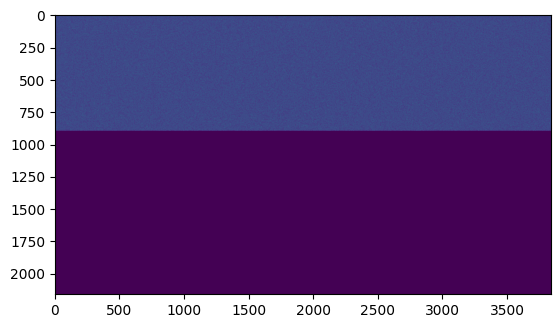

tensor([[-0.2145-0.1718j,  0.4534-0.1180j, -0.3031-0.0367j,  ...,
         -0.0514-0.4635j, -0.2470-0.0226j, -0.2050+0.3054j],
        [-0.0660-0.0085j,  0.1669+0.1569j, -0.1232+0.1963j,  ...,
         -0.8213+0.2107j,  0.0635+0.3611j,  0.1452+0.2234j],
        [-0.0380-0.3770j,  0.7770-0.5526j,  0.0769+0.5735j,  ...,
          0.2658+0.8181j, -0.0519-0.3909j,  0.3171-0.1298j],
        ...,
        [ 0.1882-0.0500j, -1.0123+0.0868j, -0.2877+0.0358j,  ...,
         -0.0030+0.5815j,  0.7587+0.2461j, -0.2617+0.2661j],
        [ 0.3030-0.2041j, -0.1305+0.8824j, -0.0304+0.4525j,  ...,
          0.4671-0.3470j,  0.3133-0.7391j,  0.4955-0.1070j],
        [-0.0218-0.3924j,  0.4416+0.4722j,  0.2854-0.1771j,  ...,
         -0.1087-0.1291j, -0.3723-0.1708j, -0.3761-0.3890j]], device='cuda:0',
       requires_grad=True)

In [3]:
# variables
Nx = 3840
Ny = 2160
wv = 520e-9
px = 3.74e-6
py = 3.74e-6 
## for Holoeye GAEA SLM

fileName_rgbd = 'Cat' #Cat
dataType = 'rgb + depth map'
distance_object =0.01

# image read
rgb = Image.open('./'+fileName_rgbd+'_rgb.jpg').convert('L')
rgb = rgb.resize((Nx,Ny))
# plt.imshow(rgb)
# plt.show()
rgb = torch.as_tensor(np.array(rgb))

# depth map read
# 일단 그냥 뎁스맵 없이 좌우 영역으로 나눠서 하자
depth_map = torch.zeros(Ny, Nx)
depth_map[:,:] = distance_object
# depth_map[:,:int(np.round(Nx/2))] = distance_object
# depth_map[:,int(np.round(Nx/2)):] = distance_object*3
# z = [distance_object,distance_object*3]
z = [distance_object]
print(z)

# carrier wave initialize
W_img = torch.randn(Ny, Nx)
W_rnd = torch.exp(1j*W_img) * torch.randn(Ny, Nx)
FT_W = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(W_rnd)))
FT_W[900:,:]=0
# FT_W[:,:2300]=0
# FT_W[:,-350:]=0
# FT_W[:200,:]=0


plt.figure()
plt.imshow(abs(FT_W).cpu().detach().numpy())
plt.show()

SSB_W = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(FT_W)))
SSB_W = SSB_W.cuda()
SSB_W.requires_grad_(True)

In [4]:
def modelGradients(weight, dxH, z, iwv):
    
    lambda_val = iwv
    W_SSB =  torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(weight)))
    W_SSB[900:,:] = 0 #일단 임의로 900쯤으로
    # W_SSB[:,:2300]=0
    # W_SSB[:,-350:]=0
    # W_SSB[:100,:]=0
    W_SSB_R = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(W_SSB)))
    Ny, Nx = weight.size()
    output = torch.zeros(len(z),Ny, Nx)
    output = output.cuda()
    
    for i in range(len(z)):
        rec1 = FresnelPropagation_as(W_SSB_R, dxH, dxH, z[i], lambda_val)
        output[i,:,:] = torch.abs(rec1)
    # min_z = [i*-1 for i in z]

    return output

In [5]:
# target setting
target = torch.ones(len(z),Ny,Nx).cuda()


d:\python\ksenv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


iteration: 1, loss 0.2996358275413513, time: 1.2472195625305176
iteration: 2, loss 0.22314853966236115, time: 1.3030402660369873
iteration: 3, loss 0.16309648752212524, time: 1.4093341827392578
iteration: 4, loss 0.11948231607675552, time: 1.514054298400879
iteration: 5, loss 0.0906321257352829, time: 1.6197710037231445
iteration: 6, loss 0.07377613335847855, time: 1.7241005897521973
iteration: 7, loss 0.06558103114366531, time: 1.8268260955810547
iteration: 8, loss 0.06270958483219147, time: 1.930238962173462
iteration: 9, loss 0.0622960701584816, time: 2.0359561443328857
iteration: 10, loss 0.06223612651228905, time: 2.1396782398223877
iteration: 11, loss 0.061263661831617355, time: 2.239964246749878
iteration: 12, loss 0.05885760113596916, time: 2.3446855545043945
iteration: 13, loss 0.055053167045116425, time: 2.4509594440460205
iteration: 14, loss 0.05022767558693886, time: 2.5546817779541016
iteration: 15, loss 0.04490770027041435, time: 2.6544153690338135
iteration: 16, loss 0.0

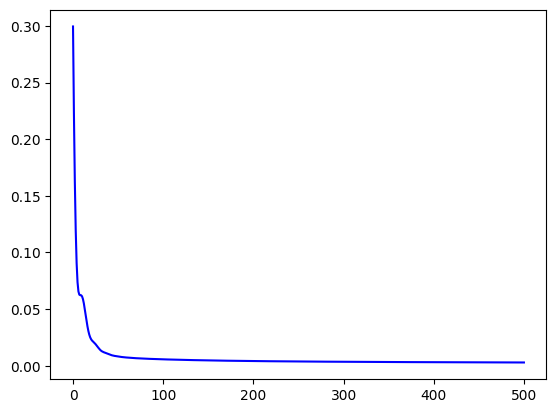

In [6]:
# training parameters
numIterations = 500
learningRate = 1e-1
s1 = torch.tensor(1.0).requires_grad_(True)
s2 = torch.tensor(1.0).requires_grad_(True)
optimizer = torch.optim.Adam([{'params': [SSB_W,s1,s2]}] , lr=  learningRate)
loss_fn = nn.MSELoss(reduction='mean')
tic = time.time()
fig, ax = plt.subplots()
x = []
y = []

for iter in range(numIterations+1):
    optimizer.zero_grad()
    recs = modelGradients(SSB_W, px, z, wv)
    # rec1= s1*recs[0,:,:] # for 2 target detph
    # rec2 = s2*recs[1,:,:]
    # rec = torch.stack([rec1,rec2],dim=0)

    rec = recs # for 1 target depth

    loss = loss_fn(rec,target)
    loss.backward()
    optimizer.step()
    toc = time.time()
    print('iteration: {}, loss {}, time: {}'.format(iter+1,loss,(toc-tic))) 
    x.append(iter)
    y.append(loss.cpu().detach().numpy())
    
plt.plot(x, y, 'b')
plt.show()
del x
del y

# torch.save(SSB_W, './weight_layers/weight_20231213_ks_iter' + str(iter)) # for save



tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


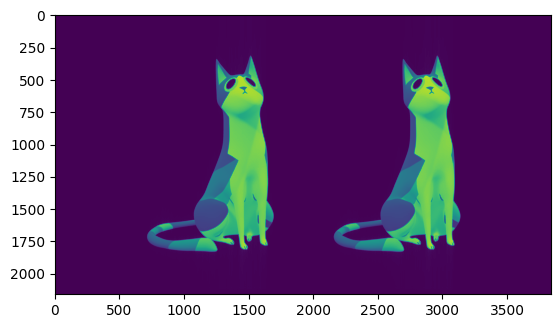

In [7]:
# proposed recon test
hologram = fn_saveHologramRGBD(rgb, depth_map, wv, px, py, Nx, Ny, SSB_W)

# match with frequency response of hologram
FT_H = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(hologram)))
FT_H[900:,:]=0

Filtered_H = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(FT_H)))
Tosave_SSB_H = torch.real(Filtered_H)-torch.min(torch.real(Filtered_H))

Tosave_SSB_H = Tosave_SSB_H/torch.max(Tosave_SSB_H)
print(torch.min(Tosave_SSB_H),torch.max(Tosave_SSB_H))
save_SSB_H = Tosave_SSB_H.cpu().detach().numpy()
save_H = np.uint8(save_SSB_H*255)
save_im = Image.fromarray(save_H)
# save_im.save('Holo.jpg') # for save


for d in z:
    rec = FresnelPropagation_as(Filtered_H, px, py, d, wv)
    plt.figure()
    plt.imshow(abs(rec).cpu().detach().numpy())
    plt.show()
    rec /= torch.max(torch.abs(rec))
    rec_np = torch.abs(rec).cpu().detach().numpy()
    rec_int = np.uint8(rec_np*255)
    im = Image.fromarray(rec_int)
    # im.save('re_layers_{}.jpg'.format(d)) # for save